<a href="https://colab.research.google.com/github/Jaksta1/Uczenie_Maszynowe_2025/blob/main/Jakub_Kownacki_praca_domowa_10_popr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------
#1. Importowanie bibliotek
-----------------------------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib.animation as animation

---------------------------------------------
#2. Definicja sieci LeNet-5
---------------------------------------------

In [ ]:

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # 1) Conv1: pad=2, 28×28→28×28×6
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        # 2) Pool1: 28×28×6→14×14×6
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # 3) Conv2: no pad, 14×14×6→10×10×16
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=0)
        # 4) Pool2: 10×10×16→5×5×16
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # 5) FC: 5*5*16=400 → 120 → 84 → 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)   # flatten 5×5×16
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

-------------------------------------------------------
#3. Przygotowanie danych i trening sieci LeNet-5 na danych MNIST
-------------------------------------------------------

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Pełny zbiór treningowy MNIST, dzielimy go na train/val
full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_ds, val_ds = random_split(full_train, [50000, 10000])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=1000, shuffle=False)

# Funkcja treningowa
def train(model, loader, optim, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optim.step()
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

# Funkcja walidacyjna
def validate(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss += criterion(logits, y).item() * x.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    return loss/total, correct/total

# Trening modelu
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 16
for ep in range(1, epochs+1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss,   val_acc   = validate(model, val_loader, criterion)
    print(f"Epoka {ep}/{epochs}: "
          f"Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f}, acc {val_acc:.4f}")

# Mrozimy wagi wytrenowanej sieci
for p in model.parameters():
    p.requires_grad = False

Epoka 1/16: Train loss 0.3260, acc 0.9018 | Val loss 0.0979, acc 0.9701
Epoka 2/16: Train loss 0.0880, acc 0.9732 | Val loss 0.0751, acc 0.9773
Epoka 3/16: Train loss 0.0618, acc 0.9816 | Val loss 0.0475, acc 0.9837
Epoka 4/16: Train loss 0.0499, acc 0.9847 | Val loss 0.0446, acc 0.9851
Epoka 5/16: Train loss 0.0414, acc 0.9872 | Val loss 0.0512, acc 0.9833
Epoka 6/16: Train loss 0.0356, acc 0.9889 | Val loss 0.0331, acc 0.9895
Epoka 7/16: Train loss 0.0305, acc 0.9901 | Val loss 0.0409, acc 0.9865
Epoka 8/16: Train loss 0.0252, acc 0.9922 | Val loss 0.0392, acc 0.9884
Epoka 9/16: Train loss 0.0233, acc 0.9926 | Val loss 0.0353, acc 0.9894
Epoka 10/16: Train loss 0.0204, acc 0.9931 | Val loss 0.0309, acc 0.9913
Epoka 11/16: Train loss 0.0172, acc 0.9946 | Val loss 0.0312, acc 0.9896
Epoka 12/16: Train loss 0.0162, acc 0.9947 | Val loss 0.0275, acc 0.9917
Epoka 13/16: Train loss 0.0138, acc 0.9955 | Val loss 0.0335, acc 0.9909
Epoka 14/16: Train loss 0.0124, acc 0.9960 | Val loss 0.0344

--------------------------------------
#Zadanie 1: CNN Dreams
--------------------------------------

In [ ]:
# CNN Dreams + snapshoty + zbiór pewności
num_classes = 10
lambdas     = [0, 0.001, 0.01, 0.1, 1.0, 10.0]
snapshots   = {lam: [] for lam in lambdas}
conf_history= {lam: [] for lam in lambdas}
target      = torch.arange(num_classes, device=device)

for lam in lambdas:
    # inicjujemy batch 10 losowych obrazów (jeden noise per class)
    inp = torch.randn((num_classes,1,28,28), device=device, requires_grad=True)
    opt = optim.Adam([inp], lr=0.1)

    for step in range(1001):
        opt.zero_grad()
        outs = model(inp)
        loss = criterion(outs, target) + lam*inp.pow(2).mean()
        loss.backward(); opt.step()
        # clamp by pozostały w [0,1]
        with torch.no_grad():
            inp.clamp_(0,1)

        # zbieranie pewności modelu w każdej iteracji
        probs = torch.softmax(outs,1)
        conf = probs[range(num_classes), range(num_classes)].detach().cpu().numpy()
        conf_history[lam].append(conf)

        # snapshot co 50 kroków
        if step % 50 == 0:
            snapshots[lam].append(inp.detach().cpu().clone())

# Animacja ewolucji
fig, axes = plt.subplots(len(lambdas), num_classes,
                         figsize=(num_classes*1.2, len(lambdas)*1.2),
                         gridspec_kw={'wspace':0.05, 'hspace':0.05})
for ax in axes.flatten(): ax.axis('off')

# nagłówki kolumn i wierszy
for j in range(num_classes):
    axes[0,j].set_title(str(j), fontsize='small', pad=4)
for i,lam in enumerate(lambdas):
    axes[i,0].text(-0.3, 0.5, f"λ={lam}", transform=axes[i,0].transAxes,
                   fontsize='small', va='center', ha='right')

def animate(frame_idx):
    imgs = []
    for i, lam in enumerate(lambdas):
        batch = snapshots[lam][frame_idx].squeeze(1).numpy()
        for j in range(num_classes):
            img = batch[j]
            img = (img - img.min())/(img.max()-img.min()+1e-8)
            im = axes[i,j].imshow(img, cmap='gray', animated=True, vmin=0, vmax=1)
            imgs.append(im)
    return imgs

num_frames = len(snapshots[lambdas[0]])
anim = animation.FuncAnimation(fig, animate, frames=num_frames,
                               interval=300, blit=True)
plt.close(fig)  # ukrywamy statyczny obraz

# Wyświetlamy animację w notebooku
HTML(anim.to_jshtml())

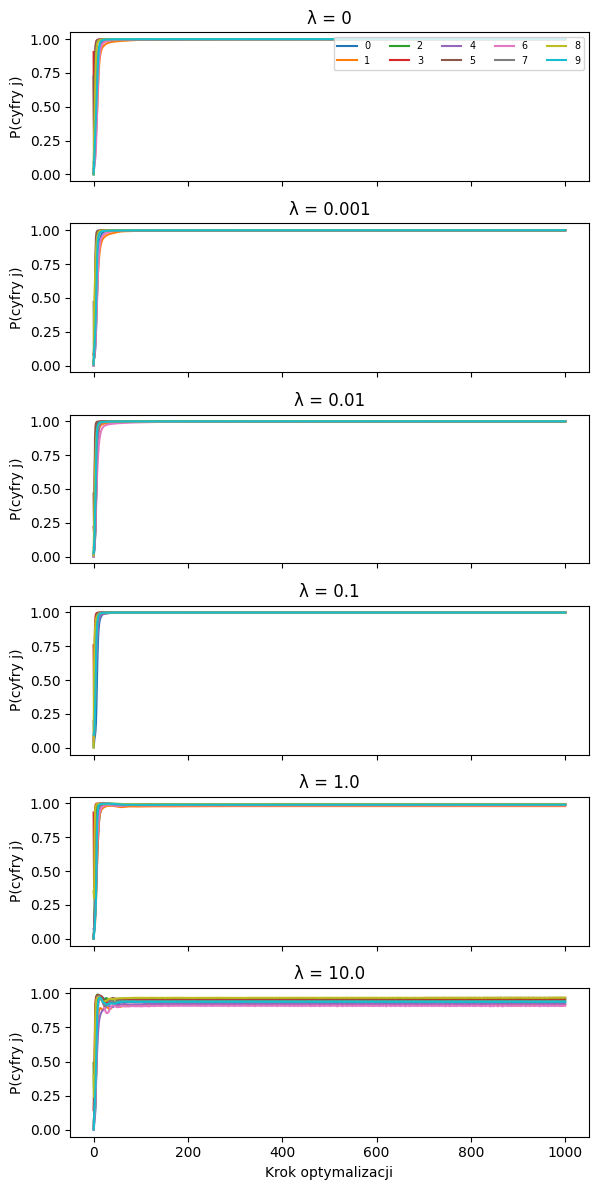

In [ ]:
# Wykres pewności klasyfikacji każdej cyfry dla każdego λ
fig2, axes2 = plt.subplots(len(lambdas), 1, figsize=(6, len(lambdas)*2), sharex=True)

for i, lam in enumerate(lambdas):
    conf_arr = np.array(conf_history[lam])  # np.shape == (400,10)
    num_points = conf_arr.shape[0]
    steps = np.arange(num_points)           # [0,1,...,399]
    ax = axes2[i]
    for j in range(num_classes):
        ax.plot(steps, conf_arr[:, j], label=str(j))
    ax.set_ylabel("P(cyfry j)")
    ax.set_title(f"λ = {lam}")
    if i == 0:
        ax.legend(ncol=5, fontsize='x-small', loc='upper right')

axes2[-1].set_xlabel("Krok optymalizacji")
plt.tight_layout()
plt.show()

---------------------------------------------
# Komentarz do Zadania 1
---------------------------------------------

##**Czy wygenerowane obrazy są bardziej czy mniej czytelne niż te wygenerowane przez sieć MLP?**
1. Bardzo małe λ (0 – 0,01): regularyzacja L₂ jest zbyt słaba, więc optymalizacja dopuszcza wysoką normę L₂ pikseli i „zaszumione” wzorce. W efekcie obrazy są pełne pikselowego szumu, linie cyfr są przerywane i bardzo trudno odczytać cyfry. Jednak w odróżnieniu od wyników działania sieci MLP tworzą się tutaj pewne struktury cyfr, obraz wynikowy nie jest jedynie pikselowym szumem.

2. Średnie λ (0,1- 1.0): regularyzacja wymusza łagodne ograniczenie normy L₂, ale pozostawia wystarczająco dużo swobody, by sieć mogła wydobyć pewne spójne zakręty i krawędzie. Niektóre cyfry są bardziej czytelne niż w przypadku sieci MLP, jednak nie wszystkie da się odróżnić ludzkim okiem.

3. Duże λ (10,0): silna kara za wartość pikseli prowadzi do nadmiernego wygładzania. Niektóre obrazy stają się prawie jednolicie ciemne, linie tracą kontrast i szczegóły. W tym przypadku cyfry są mniej czytelne niż dla sieci MLP.

##**Czy wygenerowane obrazy przypominają prawdziwe cyfry MNIST bardziej czy mniej niż w przypadku sieci MLP?**

1. Przy małych λ podobnie jak dla sieci MLP wzory są zbyt chaotyczne, a szum jest zbyt dominujący, aby dało się dostrzec prawdziwe cyfry

2. W zakresie średnich λ lokalne filtry CNN lepiej wydobywają cechy typu proste linie i łuki, w efekcie wygenerowane cyfry naśladują oryginalne próbki z MNIST lepiej niż obrazy wygenerowane dla sieci MLP.

3. Przy dużym λ obrazy stają się prawie jednolicie ciemne i trudno dostrzec w nich jakiekolwiek cyfry, w tym przypadku wygenerowane przez sieć CNN obrazy przypominają cyfry MNIST w dużo mniejszym stopniu niż w przypadku sieci MLP.

##**Dlaczego CNN daje cyfry bardziej podobne do cyfr MNIST niż MLP?**

1. Lokalne filtry i hierarchia cech: CNN uczy się najpierw wykrywać proste krawędzie i łuki, a potem łączyć je w pełne kształty – MLP traktuje każdy piksel oddzielnie, więc łatwiej „oszukuje” przez szum.

2. Translacyjna niezmienność (weight-sharing): te same filtry działają w całym obrazie, co sprzyja spójnym, symetrycznym wzorom; MLP nie ma tego priorytetu.

3. Regularyzacja L₂ (λ·∥x∥²): przy umiarkowanym λ CNN tłumi niepotrzebny szum, zachowując ostre krawędzie; MLP bez wbudowanej lokalności i z pełną wolnością pikseli generuje głównie fluktuacje wysokoczęstotliwościowe.

Warto zauważyć również, że pomimo pewnych różnic w odczycie cyfr z wygenerowanych obrazów przez człowieka, obie sieci neuronowe bardzo szybko osiągają pewność na poziomie 1 dla wszystkich cyfr (z wyjątkiem przypadku bardzo dużej kary L₂, gdzie obie sieci stabilizują pewność klasyfikacji obrazu na pewnym poziomie poniżej 1).

--------------------------------------
# Zadanie 2: oszukanie sieci CNN
--------------------------------------

In [ ]:
# Wyciągnięcie po 9 przykładów na klasę
# Zbieramy indeksy przypadków każdej klasy w val_ds
class_to_indices = {c: [] for c in range(10)}
for idx, (_, y) in enumerate(val_ds):
    c = int(y)
    if len(class_to_indices[c]) < 9:
        class_to_indices[c].append(idx)
    # jak zbierzemy już 9 na każdą klasę, przerwij
    if all(len(class_to_indices[c]) == 9 for c in range(10)):
        break

# Funkcja do utworzenia pojedynczego adv przykładu
def make_adversarial(x_orig, target_cls, model,
                     λ_l2=0.01, lr=0.01, steps=200):
    delta = (0.75 * torch.randn_like(x_orig)).to(device).requires_grad_()
    optimizer = optim.Adam([delta], lr=lr)
    target = torch.tensor([target_cls], device=device)
    ce = nn.CrossEntropyLoss()

    loss_history = []
    conf_history = []

    for _ in range(steps):
        optimizer.zero_grad()
        adv_in = (x_orig + delta).clamp(0, 1)
        logits = model(adv_in)
        loss = ce(logits, target) + λ_l2 * delta.pow(2).mean()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = torch.softmax(logits, dim=1)[0]
            conf = float(probs[target_cls])
            conf_history.append(conf)
            loss_history.append(loss.item())

    with torch.no_grad():
        adv_in = (x_orig + delta).clamp(0, 1)
        probs = torch.softmax(model(adv_in), dim=1)[0]
        final_conf = float(probs[target_cls])

    return adv_in.detach().cpu(), delta.detach().cpu(), final_conf, loss_history, conf_history

# Generowanie adv przykładów dla każdej klasy i każdego złego targetu
adv_data = {}  # adv_data[c][t] = (adv_img, confidence)
λ_l2 = 0.0
for c in range(10):
    adv_data[c] = {}
    for i, idx in enumerate(class_to_indices[c]):
        # wybieramy kolejno docelowe klasy t != c
        t = [k for k in range(10) if k != c][i]
        x_orig, y_orig = val_ds[idx]
        x_orig = x_orig.unsqueeze(0).to(device)
        adv_img, delta, conf, _, _ = make_adversarial(
            x_orig, target_cls=t, model=model,
            λ_l2=λ_l2, lr=0.1, steps=2000
        )
        adv_data[c][t] = (adv_img.squeeze(0), conf)

# Wizualizacja oryginałów vs. adversarial examples
n_rows = 10
n_cols = 1 + 9
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.5, n_rows*1.5))

for c in range(10):
    # oryginał (kolumna 0)
    idx0 = class_to_indices[c][0]
    x0, _ = val_ds[idx0]
    axes[c,0].imshow(x0.squeeze(), cmap='gray')
    axes[c,0].set_title(f"orig {c}")
    axes[c,0].axis('off')

    # adv dla każdej docelowej klasy t
    for j, t in enumerate(sorted(adv_data[c].keys()), start=1):
        adv_img, conf = adv_data[c][t]
        axes[c,j].imshow(adv_img.squeeze(), cmap='gray')
        axes[c,j].set_title(f"→{t}\nconf {conf:.2f}")
        axes[c,j].axis('off')

plt.tight_layout()
plt.show()


Powyżej znajduje się siatka przedstawiająca oryginalne cyfry z zestawu MNIST oraz ich zniekształcone wersje. Oznaczenia nad obrazkami zniekształconymi wskazują na jaką cyfrę chcieliśmy przekształcić oryginalny obrazek oraz wartość pewności (conf), z jaką sieć interpretuje dany zniekształcony obrazek jako naszą docelową cyfrę.\
Jak widać w większości przypadków sieć nie jest zbyt przekonana, że przekształcony obrazek przedstawia wskazaną przez nas cyfrę. Oryginalnych cyfr 0, 2, 5 i 8 praktycznie w ogóle nie dało się upodobnić do innych cyfr. Ale widać też, że w niektórych przypadkach uzyskujemy większe wartości conf, na przykład przekształcając szóstkę na tróję uzyskaliśmy conf o wartości 0.50, przekształcając siódemkę na dziewiątkę uzyskaliśmy conf o wartości 0.46 oraz przekształcając dziewiątkę na piątkę uzyskaliśmy conf o wartości 0.38. Ciekawe jest też, że cyfra dziewięć przekształcona na piątkę jest bardzo podobna do litery g.

In [ ]:
num_per_class = 30
class_to_indices = {c: [] for c in range(10)}
for idx, (_, y) in enumerate(val_ds):
    c = int(y)
    if len(class_to_indices[c]) < num_per_class:
        class_to_indices[c].append(idx)
    if all(len(class_to_indices[c]) == num_per_class for c in range(10)):
        break


# Ustawienie parametrów
lambda_list = [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0]
results = {}

for lambda_l2 in lambda_list:
    success = 0
    total = 0
    noise_norms = []
    records = []  # zmienna przechowująca wyniki (orig, adv, orig_cls, target, success_flag, conf, noise_norm)

    for c in range(10):
        # przygotowujemy listę możliwych celów (zawsze 9 elementów)
        targets = [k for k in range(10) if k != c]
        for i, idx in enumerate(class_to_indices[c]):
            # jeśli i >= len(targets), owijamy go modułem
            t = targets[i % len(targets)]
            x_orig, y_orig = val_ds[idx]
            x_orig = x_orig.unsqueeze(0).to(device)
            adv_img, delta, conf, loss_hist, conf_hist   = make_adversarial(
                x_orig, target_cls=t, model=model,
                λ_l2=lambda_l2, lr=0.1, steps=2000
            )
            pred = model(adv_img.to(device)).argmax(dim=1).item()
            success_flag = (pred == t)
            total += 1
            success += int(success_flag)
            noise_norms.append(delta.norm().item())
            records.append((x_orig.cpu().squeeze(), adv_img, c, t, success_flag, conf, delta.norm().item()))

    success_rate = success / total
    avg_norm = sum(noise_norms) / len(noise_norms)
    results[lambda_l2] = {'success_rate': success_rate,
                          'avg_noise_norm': avg_norm,
                          'records': records}
    print(f"Lambda {lambda_l2}: success_rate={success_rate:.2f}, avg_noise_norm={avg_norm:.4f}")

# Wykres wpływu wartości lambda na success_rate i normę szumu
lambdas = list(results.keys())
srs = [results[l]['success_rate'] for l in lambdas]
anns = [results[l]['avg_noise_norm'] for l in lambdas]

plt.figure(figsize=(6,4))
plt.plot(lambdas, srs, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (l2)')
plt.ylabel('Attack Success Rate')
plt.title('Success Rate vs. Lambda')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(lambdas, anns, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (l2)')
plt.ylabel('Average Noise Norm')
plt.title('Noise Norm vs. Lambda')
plt.grid(True)
plt.tight_layout()
plt.show()



--------------------------------------
# Komentarz do Zadania 2
--------------------------------------

Jak widać z wyników raportu:
1. ilość sukcesów: rosnąca wielkość λ w małym stopniu zmniejszyła ilość zniekształconych obrazków przypisanych do innej klasy niż oryginalna klasa obrazka. Success_rate dla wszystkich λ jest bardzo małe, równe 0.01, z wyjątkiem λ = 10, gdzie spadło do poziomu około 0.0065.
2. Norma szumu: z wykresu można odczytać, że zwiększające się λ wpływa na zmniejszenie normy szumu. Dla najmniejszych wartości λ norma szumu jest ponad dwa razy większa niż dla największej wartości λ = 10.
3. Przykłady oryginalny vs zniekształcony obrazek: wybrane tutaj jest kilka przykładów oryginalnych obrazków i zniekształconych. Widać, że człowiek z łatwością może stwierdzić, że na orygnalnym i przerobionym obrazku jest ta sama cyfra. Jednak dla sieci neuronowej LeNet-5 nie jest to takie oczywiste, gdyż przerobione obrazki uzyskują wysokie wartości pewności, że na obrazku przerobionym jest inna cyfra niż ta z oryginalnego obrazka.

In [ ]:
# Wybieramy najlepsze przykłady dla wybranej lambda
best_lambda = lambda_list[2]
best_recs = results[best_lambda]['records']
# Filtrujemy tylko udane ataki
best_success = [r for r in best_recs if r[4]]
# Wybieramy do 10 najlepszych przykładów
sample = best_success[:10]

# Pokazujemy oryginalne obrazy vs adversarial + osobne wykresy historii
for i, (x_o, x_a, orig_c, tgt, ok, conf, norm, loss_hist, conf_hist) in enumerate(sample):
    # Obrazy: oryginalny i adversarial
    fig_img, axs_img = plt.subplots(1, 2, figsize=(6, 3))
    axs_img[0].imshow(x_o.squeeze(), cmap='gray')
    axs_img[0].set_title(f"Orig {orig_c}")
    axs_img[0].axis('off')

    axs_img[1].imshow(x_a.squeeze(), cmap='gray')
    axs_img[1].set_title(f"Adv→{tgt}\nconf={conf:.2f}, norm={norm:.3f}")
    axs_img[1].axis('off')

    plt.suptitle(f"Example {i+1} - Images")
    plt.tight_layout()
    plt.show()

    # Wykres: Loss history
    plt.figure(figsize=(5, 3))
    plt.plot(loss_hist, label='Loss', color='blue')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Example {i+1} - Loss History")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Wykres: Confidence history
    plt.figure(figsize=(5, 3))
    plt.plot(conf_hist, label='Confidence', color='orange')
    plt.xlabel("Iteration")
    plt.ylabel("Confidence")
    plt.title(f"Example {i+1} - Confidence History")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Widać również z wykresów pewności w czasie treningu, że sieć szybko otrzymuje pewien poziom pewności klasyfikacji i na nim się zatrzymuje do końca treningu.